Simple Tag
https://www.pettingzoo.ml/mpe/simple_tag

> This is a predator-prey environment. Good agents (green) are faster and receive a negative reward for being hit by adversaries (red) (-10 for each collision). Adversaries are slower and are rewarded for hitting good agents (+10 for each collision). Obstacles (large black circles) block the way. By default, there is 1 good agent, 3 adversaries and 2 obstacles.

Baseline agent algorithm with experience replay buffer

In [1]:
import os
import time
import enum
import math
import random
import collections
import statistics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class TimeDelta(object):
    def __init__(self, delta_time):
        """Convert time difference in seconds to days, hours, minutes, seconds.
        
        Parameters
        ==========
        delta_time : float
            Time difference in seconds.
        """
        self.fractional, seconds = math.modf(delta_time)
        seconds = int(seconds)
        minutes, self.seconds = divmod(seconds, 60)
        hours, self.minutes = divmod(minutes, 60)
        self.days, self.hours = divmod(hours, 24)
    
    def __repr__(self):
        return f"{self.days}-{self.hours:02}:{self.minutes:02}:{self.seconds + self.fractional:02}"
        
from pettingzoo.mpe import simple_tag_v2
from pettingzoo.utils import random_demo

Arguments in instantiate environment.

- num_good: number of good agents
- num_adversaries: number of adversaries
- num_obstacles: number of obstacles
- max_cycles: number of frames (a step for each agent) until game terminates
- continuous_actions: Whether agent action spaces are discrete(default) or continuous

In [2]:
env = simple_tag_v2.env(
    num_good=3,
    num_adversaries=3,
    num_obstacles=2,
    max_cycles=300,
    continuous_actions=False
).unwrapped

### What are the environment parameters?

Adversaries (red) capture non-adversary (green). The map is a 2D grid and everything is initialized in the region [-1, +1]. There doesn't seem to be position clipping for out of bounds, but non-adversary agent are penalized for out of bounds.
Agent's observation is a ndarray vector of concatenated data in the following order:

1. current velocity (2,)
2. current position (2,)
3. relative position (2,) of each landmark
4. relative position (2,) of each other agent
5. velocity (2,) of each other non-adversary agent

When there are 3 adverseries and 3 non-adversaries, then advarsary observation space is 24 dimensional and non-advarsary observation space is 22 dimensional.

The environment is sequential. Agents move one at a time. Agents are either `adversary_*` for adversary or `agent_*` for non-adversary.

Actions:

- 0 is NOP
- 1 is go left
- 2 is go right
- 3 is go down
- 4 is go up

### How to train the agents?

- Use the differental inter-agent learning (DIAL) algorithm.
- Use parameter sharing for DAIL agents. Separate parameter sets for adversary agents and good agents.
- It's not entirely clear the authors accumulate gradients for differentiable communication, but it 

Messages are vectors. Length 4, 5 should work.

Concatenate the messages from all the actors and add them to the message input for the current agent.

The names of agents are: 
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2

In [3]:
env.reset()

In [4]:
def get_agent_counts():
    all_agents = 0
    adversaries = 0
    for agent in env.world.agents:
        all_agents += 1
        adversaries += 1 if agent.adversary else 0
    good_agents = all_agents - adversaries
    return (adversaries, good_agents)

def process_config(config):
    for k, v in config.common.items():
        config.adversary[k] = v
        config.agent[k] = v

n_adversaries, n_good_agents = get_agent_counts()
config = AttrDict(
    discount = 0.99,
    epsilon = 0.05,
    n_episodes=10_000,
    batch_size=16,
    update_target_interval=32,
    report_interval=64,
    clip_grad_norm=2.,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    common=AttrDict(
        message_size=4,
        hidden_size=128,
        n_actions=env.action_space(env.agent_selection).n,
        n_rnn_layers=2,
        apply_bn=False,
    ),
    adversary=AttrDict(
        n_agents=n_adversaries,
        observation_shape=env.observation_space("adversary_0").shape

    ),
    agent=AttrDict(
        n_agents=n_good_agents,
        observation_shape=env.observation_space("agent_0").shape
    )
)
process_config(config)

class Container(object):
    """Container of messages and hidden states of agents in environment."""
    
    def reset(self):
        
        for idx in range(config.adversary.n_agents):
            self.__message_d[f"adversary_{idx}"] = torch.zeros(
                self.config.adversary.message_size*(config.adversary.n_agents - 1),
                dtype=torch.float, device=self.device
            )
            self.__hidden_d[f"adversary_{idx}"]  = torch.zeros(
                (config.adversary.n_rnn_layers, 1, self.config.adversary.hidden_size,),
                dtype=torch.float, device=self.device
            )
        for idx in range(config.agent.n_agents):
            self.__message_d[f"agent_{idx}"] = torch.zeros(
                self.config.agent.message_size*(config.agent.n_agents - 1),
                dtype=torch.float, device=self.device
            )
            self.__hidden_d[f"agent_{idx}"]  = torch.zeros(
                (config.agent.n_rnn_layers, 1, self.config.agent.hidden_size,),
                dtype=torch.float, device=self.device
            )
        
    def __init__(self, config):
        self.config = config
        self.device = self.config.device
        self.__message_d = {}
        self.__hidden_d = {}
        self.reset()
    
    def get_message(self, agent_name):
        return self.__message_d[agent_name]

    def get_hidden(self, agent_name):
        return self.__hidden_d[agent_name]

    def update_message(self, agent_name, message):
        """Update message cache.
        
        Messages of multiple agents are concatenated together.
        For example, if agent 2 receives messages from agents 0, 1, and 3 then
        the message is a vector of the form: [ 0's message, 1's message, 3's message ]
        """
        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        message_size = self.config[agent_type].message_size
        for jdx in range(config[agent_type].n_agents):
            if jdx < agent_idx:
                start_idx = message_size * (agent_idx - 1)
            elif jdx == agent_idx:
                # do not update message to oneself
                continue
            else:
                # agent_idx < jdx
                start_idx = message_size * agent_idx
            end_idx   = start_idx + self.config[agent_type].message_size
            # print(jdx, agent_idx, self.__message_d[f"{agent_type}_{jdx}"].shape, start_idx, end_idx)
            messages = self.__message_d[f"{agent_type}_{jdx}"]
            self.__message_d[f"{agent_type}_{jdx}"] = \
                    torch.hstack((messages[:start_idx], message, messages[end_idx:]))

    def update_hidden(self, agent_name, hidden):
        self.__hidden_d[agent_name] = hidden


In [5]:
class SimpleTagNet(torch.nn.Module):
    """NN Model for the agents. Both good agents and adversaries use this model."""
        
    def __init__(self, config, agent_type):
        super().__init__()
        # self.config = config
        self.device      = config.device
        self.observation_size = math.prod(config[agent_type].observation_shape)
        self.n_agents    = config[agent_type].n_agents
        self.n_actions   = config[agent_type].n_actions
        self.apply_bn    = config[agent_type].apply_bn
        self.hidden_size = config[agent_type].hidden_size
        self.n_output    = self.n_actions
        
        self.agent_lookup    = torch.nn.Embedding(self.n_agents, self.hidden_size)
        self.observation_mlp = torch.nn.Sequential(collections.OrderedDict([
            ("linear", torch.nn.Linear(self.observation_size, self.hidden_size)),
            ("relu", torch.nn.ReLU(inplace=True)),
        ]))
        self.output_mlp = torch.nn.Sequential()
        self.output_mlp.add_module("linear", torch.nn.Linear(self.hidden_size, self.hidden_size))
        self.output_mlp.add_module("relu", torch.nn.ReLU(inplace=True))
        self.output_mlp.add_module("linear", torch.nn.Linear(self.hidden_size, self.n_output))
    
    def forward(self, agent_idx, observation):
        """Apply DQN to episode step.
        
        Parameters
        ==========
        agent_idx : int
            Index of agent
        observation : ndarray
            The observation vector obtained from the environment.
        
        Returns
        =======
        torch.Tensor
            Vector of Q-value associated with each action.
        """
        agent_idx   = torch.tensor(agent_idx, dtype=torch.int, device=self.device)
        observation = torch.tensor(observation, dtype=torch.float, device=self.device)
        z_a = self.agent_lookup(agent_idx)
        z_o = self.observation_mlp(observation)
        # z has shape (N=1, L=1, H_in=128)
        z = z_a + z_o
        Q = self.output_mlp(z)
        return Q


In [8]:
def choose_action(config, agent_type, Q, is_val=False):
    if not is_val and random.random() < config.epsilon:
        return random.randrange(config[agent_type].n_actions)
    else:
        return torch.argmax(Q).item()

def run_episode(config, adversary_net, agent_net, should_render=False, is_val=False):
    """Run one episodes.
    
    inputs consist of observation, message (backprop), hidden (backprop) indexed by agent
    outputs consist of action, q-value of action (backprop), reward, done indexed by (step, agent)
    
    Returns
    =======
    AttrDict
        Contains episode metrics:
        - steps : number of steps. All agents take an action at each step.
        - reward : episodic rewards indexed by ('adversary', 'agent').
        - step_records : list of quantities produced indiced by step, ('adversary', 'agent'), agent index.
          Each step record has:
            + observation
            + Q
            + reward
            + done
        - loss : contains episodic losses indexed by ('adversary', 'agent'). To be updated by train_agents()
    """
    episode = AttrDict(
        steps=0,
        reward=AttrDict(adversary=0, agent=0),
        step_records=[],
        loss=AttrDict(adversary=0, agent=0)
    )
    n_agents = config.adversary.n_agents + config.agent.n_agents
    step_record = None
    
    env.reset()
    for agent_step_idx, agent_name in enumerate(env.agent_iter()):
        if should_render:
            env.render()
        if agent_step_idx % n_agents == 0:
            episode.steps += 1
            step_record = AttrDict(adversary={}, agent={})
            episode.step_records.append(step_record)
            
        obs_curr, reward, done, _ = env.last()
        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        if done:
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=None,
                Q=None,
                reward=reward,
                done=done,
            )
            env.step(None)
            continue

        if agent_type == "adversary":
            Q_curr = adversary_net(agent_idx, obs_curr)
        else:
            # agent type is synonymous with good agent
            Q_curr = agent_net(agent_idx, obs_curr)

        action = choose_action(config, agent_type, Q_curr, is_val=is_val)
        env.step(action)
        step_record[agent_type][agent_idx] = AttrDict(
            # inputs to network
            observation=obs_curr,
            # outputs of network / inputs to environment
            action=action,
            Q=Q_curr,
            # output of environment
            reward=reward,
            done=done,
        )
        episode.reward[agent_type] += reward
    
    return episode

def train_agents(config, batch, adversary_net, agent_net,
                 adversary_target_net, agent_target_net,
                 adversary_optimizer, agent_optimizer):
    """Compute loss of episode and update agent weights.
    """
    device = config.device
    discount = torch.tensor(config.discount, dtype=torch.float, device=device)
    adversary_loss = torch.tensor(0., device=device)
    agent_loss = torch.tensor(0., device=device)
    for episode in batch:
        for step_idx in range(episode.steps):
            for agent_idx in episode.step_records[step_idx].adversary.keys():
                curr_record = episode.step_records[step_idx].adversary[agent_idx]
                if curr_record.done:
                    # agent is done at this step
                    continue
                next_record = episode.step_records[step_idx + 1].adversary[agent_idx]
                r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
                y = None
                if next_record.done:
                    # agent terminates at next step
                    y = r
                else:
                    next_o = next_record.observation
                    with torch.no_grad():
                        target_Q = adversary_target_net(agent_idx, next_o)
                        max_target_Q = torch.max(target_Q)
                        y = r + discount*max_target_Q
                u = curr_record.action
                Q_u = curr_record.Q[u]
                adversary_loss += torch.pow(y - Q_u, 2.)

            for agent_idx in episode.step_records[step_idx].agent.keys():
                curr_record = episode.step_records[step_idx].agent[agent_idx]
                if curr_record.done:
                    # agent is done at this step
                    continue
                next_record = episode.step_records[step_idx + 1].agent[agent_idx]
                r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
                y = None
                if next_record.done:
                    # agent terminates at next step
                    y = r
                else:
                    next_o = next_record.observation
                    with torch.no_grad():
                        target_Q = agent_target_net(agent_idx, next_o)
                        max_target_Q = torch.max(target_Q)
                        y = r + discount*max_target_Q
                u = curr_record.action
                Q_u = curr_record.Q[u]
                agent_loss += torch.pow(y - Q_u, 2.)
    
    n_adversary = torch.tensor(config.adversary.n_agents, dtype=torch.float, device=device)
    n_agent = torch.tensor(config.agent.n_agents, dtype=torch.float, device=device)
    bs = torch.tensor(config.batch_size, dtype=torch.float, device=device)
    adversary_loss = adversary_loss / (bs + n_adversary)
    agent_loss     = agent_loss / (bs + n_agent)
    adversary_optimizer.zero_grad()
    agent_optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(adversary_net.parameters(), config.clip_grad_norm)
    torch.nn.utils.clip_grad_norm_(agent_net.parameters(), config.clip_grad_norm)
    adversary_loss.backward()
    agent_loss.backward()
    adversary_optimizer.step()
    agent_optimizer.step()
    episode.loss = AttrDict(adversary=adversary_loss.item(), agent=agent_loss.item())
    

def train(config):
    """
    - Use parameter sharing between agents of the same class.
    - Good agents use one RL model, adversaries use another RL model.
      Train the agents side by side.
    - Separate, disjoint communication channels for two classes of agents,
      maintained by a container to store the messages.
    """
    print("Training the agents...")
    os.makedirs("models/batched-baseline", exist_ok=True)
    t0 = time.time()
    device = config.device
    adversary_net = SimpleTagNet(config, "adversary").to(device)
    agent_net = SimpleTagNet(config, "agent").to(device)
    adversary_target_net = SimpleTagNet(config, "adversary").to(device)
    agent_target_net = SimpleTagNet(config, "agent").to(device)
    adversary_target_net.eval()
    agent_target_net.eval()
    print("Created the agent nets.")
    adversary_optimizer = torch.optim.RMSprop(adversary_net.parameters())
    agent_optimizer = torch.optim.RMSprop(agent_net.parameters())
    logger = AttrDict(
        episodic_losses=AttrDict(adversary=[], agent=[]),
        episodic_rewards=AttrDict(adversary=[], agent=[]),
        episodic_message_maxsum=AttrDict(adversary=[], agent=[])
    )
    def update_targets():
        adversary_target_net.load_state_dict(adversary_net.state_dict())
        agent_target_net.load_state_dict(agent_net.state_dict())
    print("Initial update of target nets")
    update_targets()
    
    batch = []
    print("Beginning the episodes...")
    for episode_idx in range(config.n_episodes):
        # Run an episode
        episode = run_episode(config, adversary_net, agent_net,
                              should_render=episode_idx % config.report_interval == 0 and episode_idx > 0)
        batch.append(episode)
        
        # Train on the episode
        if episode_idx % config.batch_size == 0 and episode_idx > 0:
            train_agents(config, batch, adversary_net, agent_net,
                         adversary_target_net, agent_target_net,
                         adversary_optimizer, agent_optimizer)
            batch = []
        
        # Logging the reward and los
        logger.episodic_losses.adversary.append(episode.loss.adversary)
        logger.episodic_losses.agent.append(episode.loss.agent)
        logger.episodic_rewards.adversary.append(episode.reward.adversary)
        logger.episodic_rewards.agent.append(episode.reward.agent)

        if episode_idx % config.update_target_interval == 0 and episode_idx > 0:
            # Update double network
            update_targets()
        
        if episode_idx % config.report_interval == 0 and episode_idx > 0:
            # Logging
            t1 = time.time()
            tdelta = TimeDelta(round(t1 - t0, 0))
            print(f"on episode {episode_idx} (time taken so far: {tdelta})")
            mean_loss_adversary = statistics.fmean(logger.episodic_losses.adversary[-config.report_interval:])
            mean_loss_agent = statistics.fmean(logger.episodic_losses.agent[-config.report_interval:])
            mean_reward_adversary = statistics.fmean(logger.episodic_rewards.adversary[-config.report_interval:])
            mean_reward_agent = statistics.fmean(logger.episodic_rewards.agent[-config.report_interval:])
            print(f"     mean loss: adversary {mean_loss_adversary}, agent {mean_loss_agent}")
            print(f"     mean reward: adversary {mean_reward_adversary}, agent {mean_reward_agent}")
            
            torch.save(adversary_net.state_dict(), f"models/batched-baseline/adversary-net-{episode_idx}.pth")
            torch.save(agent_net.state_dict(), f"models/batched-baseline/agent-net-{episode_idx}.pth")
    
    return adversary_net, agent_net, logger

In [9]:
# train model
adversary_net, agent_net, logger = train(config)

Training the agents...
Created the agent nets.
Initial update of target nets
Beginning the episodes...
on episode 64 (time taken so far: 0-00:01:35.0)
     mean loss: adversary 45578.02366542816, agent 4035.12215423584
     mean reward: adversary 54.375, agent -3847.972675087753
on episode 128 (time taken so far: 0-00:03:7.0)
     mean loss: adversary 42.7421612739563, agent 112.09345436096191
     mean reward: adversary 62.8125, agent -699.7811212829506
on episode 192 (time taken so far: 0-00:04:40.0)
     mean loss: adversary 46.712759017944336, agent 153.68387985229492
     mean reward: adversary 68.4375, agent -853.5938138342701
on episode 256 (time taken so far: 0-00:06:16.0)
     mean loss: adversary 1861.3388833999634, agent 172.19524765014648
     mean reward: adversary 43.125, agent -956.9395410755142
on episode 320 (time taken so far: 0-00:07:48.0)
     mean loss: adversary 233.45912170410156, agent 116.75400161743164
     mean reward: adversary 39.84375, agent -736.521891304

on episode 3008 (time taken so far: 0-01:12:1.0)
     mean loss: adversary 8893532.3125, agent 62.51217269897461
     mean reward: adversary 30.0, agent -486.7960905062996
on episode 3072 (time taken so far: 0-01:13:32.0)
     mean loss: adversary 11178274.25, agent 54.85436534881592
     mean reward: adversary 33.28125, agent -442.6507336273601
on episode 3136 (time taken so far: 0-01:15:4.0)
     mean loss: adversary 9074483.875, agent 47.50102615356445
     mean reward: adversary 36.09375, agent -380.72672289607647
on episode 3200 (time taken so far: 0-01:16:36.0)
     mean loss: adversary 13330616.5, agent 45.38941192626953
     mean reward: adversary 25.3125, agent -395.7210927350198
on episode 3264 (time taken so far: 0-01:18:7.0)
     mean loss: adversary 6449438.25, agent 60.31577491760254
     mean reward: adversary 44.0625, agent -439.8082307987484
on episode 3328 (time taken so far: 0-01:19:38.0)
     mean loss: adversary 7270848.625, agent 44.01920032501221
     mean reward

on episode 6016 (time taken so far: 0-02:23:39.0)
     mean loss: adversary 42967188.0, agent 46.295684814453125
     mean reward: adversary 40.3125, agent -369.71354966260157
on episode 6080 (time taken so far: 0-02:25:10.0)
     mean loss: adversary 39647933.5, agent 59.57460308074951
     mean reward: adversary 34.6875, agent -428.17046059848025
on episode 6144 (time taken so far: 0-02:26:41.0)
     mean loss: adversary 38534527.0, agent 34.084110260009766
     mean reward: adversary 22.5, agent -345.8630825432408
on episode 6208 (time taken so far: 0-02:28:13.0)
     mean loss: adversary 38224249.0, agent 55.01156568527222
     mean reward: adversary 22.03125, agent -450.8226034858394
on episode 6272 (time taken so far: 0-02:29:44.0)
     mean loss: adversary 38332844.0, agent 49.749505043029785
     mean reward: adversary 29.53125, agent -395.26975944709704
on episode 6336 (time taken so far: 0-02:31:15.0)
     mean loss: adversary 33850198.5, agent 58.963051319122314
     mean re

on episode 9024 (time taken so far: 0-03:35:14.0)
     mean loss: adversary 8605281.5, agent 57.26376152038574
     mean reward: adversary 36.09375, agent -469.66242334660865
on episode 9088 (time taken so far: 0-03:36:45.0)
     mean loss: adversary 8291688.0, agent 50.0185661315918
     mean reward: adversary 31.40625, agent -393.6620737289095
on episode 9152 (time taken so far: 0-03:38:16.0)
     mean loss: adversary 7914985.0, agent 40.704402923583984
     mean reward: adversary 21.09375, agent -364.59971933891524
on episode 9216 (time taken so far: 0-03:39:48.0)
     mean loss: adversary 8049917.75, agent 39.17176580429077
     mean reward: adversary 31.875, agent -378.0134584107463
on episode 9280 (time taken so far: 0-03:41:20.0)
     mean loss: adversary 8125262.125, agent 59.5505576133728
     mean reward: adversary 39.375, agent -476.4342478821185
on episode 9344 (time taken so far: 0-03:42:51.0)
     mean loss: adversary 7605453.25, agent 45.483975410461426
     mean reward:

In [ ]:
adversary_net = SimpleTagNet(config, "adversary").to(config.device)
agent_net = SimpleTagNet(config, "agent").to(config.device)
adversary_net.load_state_dict(torch.load('./models/batched-baseline/adversary-net-9984.pth'))
agent_net.load_state_dict(torch.load('./models/batched-baseline/agent-net-9984.pth'))

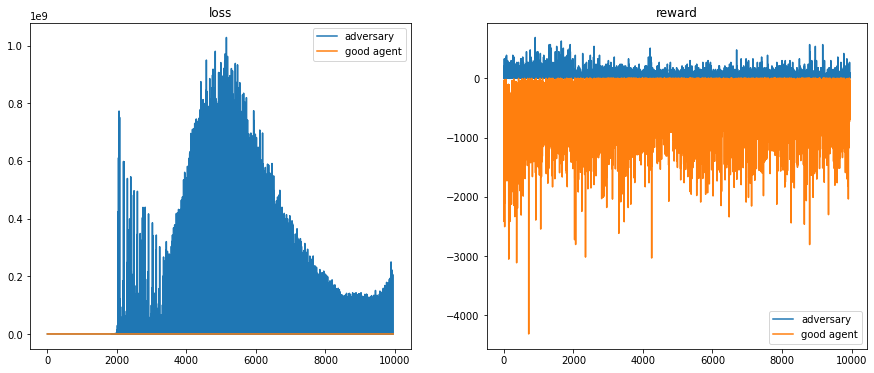

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.ravel()

axes[0].plot(logger.episodic_losses.adversary[50:], label="adversary")
axes[0].plot(logger.episodic_losses.agent[50:], label="good agent")
axes[0].set_title("loss")
axes[0].legend()

axes[1].plot(logger.episodic_rewards.adversary[50:], label="adversary")
axes[1].plot(logger.episodic_rewards.agent[50:], label="good agent")
axes[1].set_title("reward")
axes[1].legend()
None

In [16]:
def visualize(config, adversary_net, agent_net):
    container = Container(config)
    adversary_net.eval()
    agent_net.eval()
    with torch.no_grad():
        return run_episode(config, adversary_net, agent_net, should_render=True, is_val=True)

episode = visualize(config, adversary_net, agent_net)
print("episode steps", episode.steps)
print("episode rewards", *episode.reward.items())

episode steps 301
episode rewards ('adversary', 0.0) ('agent', 0.0)
